# Quickstart tutorial

The basic functionality of the catalog is demonstrated in this tutorial. You can download the Jupyter notebook rendered below from [here](https://github.com/ACCESS-NRI/access-nri-intake-catalog/blob/main/docs/usage/quickstart.ipynb) and run it yourself in an NCI ARE instance.

## Import the catalog 

In [1]:
import intake

nri_cat = intake.cat.access_nri

With that, we can now search and load ~3 PB of data without having to know where the data is or how it's structured. 

The catalog includes a wide variety of climate data products. Each entry in the catalog corresponds to an Intake source that refers to a product which may comprise many files (if this sentence didn't make sense, go back and read [What is it](what.rst)). You can scroll through the products below and get an idea for what each product is by looking at the entry in the description column.

In [2]:
nri_cat

,model,description,realm,frequency,variable
name,,,,,
01deg_jra55v13_ryf9091,{ACCESS-OM2},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},"{seaIce, ocean}","{1mon, 1day, fx, 3hr, 3mon}","{flatn_ai_m, total_ocean_evap_heat, tx_trans, total_ocean_evap, tx_trans_submeso, surface_salt, kmu, river, blkmask, TLON, average_DT, salt_surface_ave, opening_m, temp_rivermix, pme_river, TLAT, ..."
01deg_jra55v140_iaf,{ACCESS-OM2},{Cycle 1/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{seaIce, ocean}","{fx, 1mon, 1day}","{flatn_ai_m, total_ocean_evap_heat, tx_trans, total_ocean_evap, surface_salt, kmu, river, blkmask, TLON, average_DT, uvel, salt_surface_ave, opening_m, pme_river, TLAT, uvel_m, temp_global_ave, ag..."
01deg_jra55v140_iaf_cycle2,{ACCESS-OM2},{Cycle 2/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{seaIce, ocean}","{fx, 1mon, 1day}","{flatn_ai_m, melts_m, total_ocean_evap_heat, tx_trans, total_ocean_evap, surface_salt, kmu, river, blkmask, TLON, average_DT, uvel, salt_surface_ave, opening_m, pme_river, TLAT, usurf, uvel_m, tem..."
01deg_jra55v140_iaf_cycle3,{ACCESS-OM2},{Cycle 3/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{seaIce, ocean}","{fx, 1mon, 1day}","{flatn_ai_m, melts_m, total_ocean_evap_heat, tx_trans, total_ocean_evap, surface_salt, kmu, river, blkmask, TLON, average_DT, uvel, salt_surface_ave, opening_m, pme_river, TLAT, usurf, uvel_m, tem..."
01deg_jra55v140_iaf_cycle4,{ACCESS-OM2},{Cycle 4/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{seaIce, ocean}","{6hr, 1mon, 1day, fx, 3hr}","{det, alidr_ai, total_ocean_evap, kmu, adic_xflux_adv, TLON, salt_surface_ave, npp2d, npp_intmld, salt_global_ave, time_bounds, caco3_yflux_adv, strairy_m, pe_tot, fhocn_ai_m, ty_trans_nrho_submes..."
01deg_jra55v140_iaf_cycle4_jra55v150_extension,{ACCESS-OM2},{Extensions of cycle 4/4 of 0.1 degree ACCESS-OM2 + WOMBAT BGC global model configuration with JRA55-do v1.5.0 and v1.5.0.1 OMIP2 interannual forcing},"{seaIce, ocean}","{fx, 0hr, 1mon, 1day}","{flatn_ai_m, melts_m, total_ocean_evap_heat, tx_trans, det, total_ocean_evap, PP_net_m, surface_salt, kmu, adic_xflux_adv, river, fN_ai_m, blkmask, TLON, average_DT, uvel, fswthru_ai_m, phy_intmld..."
01deg_jra55v150_iaf_cycle1,{ACCESS-OM2},{Cycle 1/1 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do \nv1.5.0 OMIP2 interannual forcing},"{seaIce, ocean}","{fx, 1mon, 1day}","{tx_trans, surface_salt, kmu, river, blkmask, TLON, average_DT, pme_river, TLAT, age_global, swflx, hi_m, temp_yflux_adv_int_z, average_T1, time_bounds, dzt, ty_trans_nrho_submeso, lw_heat, eta_no..."
025deg_jra55_iaf_omip2_cycle1,{ACCESS-OM2},{Cycle 1/6 of 0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},"{seaIce, ocean}","{fx, 1yr, 1mon, 1day}","{diff_cbt_s, evap_ai_m, flatn_ai_m, melts_m, total_ocean_evap_heat, tx_trans, eta_adjust, ty_trans_gm, salt_rhodzt, total_ocean_evap, tx_trans_submeso, kmu, ice_present_m, blkmask, TLON, average_D..."
025deg_jra55_iaf_omip2_cycle2,{ACCESS-OM2},{Cycle 1/6 of 0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},"{seaIce, ocean}","{fx, 1yr, 1mon, 1day}","{diff_cbt_s, evap_ai_m, flatn_ai_m, melts_m, total_ocean_evap_heat, tx_trans, eta_adjust, ty_trans_gm, salt_rhodzt, total_ocean_evap, tx_trans_submeso, kmu, ice_present_m, blkmask, TLON, average_D..."


## Search for products

We can search on the columns in this catalog. For example, we could search for all products that use the model `ACCESS-OM2`. The `.search` method returns another catalog with entries that satisfy our search criteria.

In [3]:
nri_cat2 = nri_cat.search(model="ACCESS-OM2")
nri_cat2

,model,description,realm,frequency,variable
name,,,,,
01deg_jra55v13_ryf9091,{ACCESS-OM2},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},"{seaIce, ocean}","{1mon, 1day, fx, 3hr, 3mon}","{flatn_ai_m, total_ocean_evap_heat, tx_trans, total_ocean_evap, tx_trans_submeso, surface_salt, kmu, river, blkmask, TLON, average_DT, salt_surface_ave, opening_m, temp_rivermix, pme_river, TLAT, ..."
01deg_jra55v140_iaf,{ACCESS-OM2},{Cycle 1/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{seaIce, ocean}","{fx, 1mon, 1day}","{flatn_ai_m, total_ocean_evap_heat, tx_trans, total_ocean_evap, surface_salt, kmu, river, blkmask, TLON, average_DT, uvel, salt_surface_ave, opening_m, pme_river, TLAT, uvel_m, temp_global_ave, ag..."
01deg_jra55v140_iaf_cycle2,{ACCESS-OM2},{Cycle 2/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{seaIce, ocean}","{fx, 1mon, 1day}","{flatn_ai_m, melts_m, total_ocean_evap_heat, tx_trans, total_ocean_evap, surface_salt, kmu, river, blkmask, TLON, average_DT, uvel, salt_surface_ave, opening_m, pme_river, TLAT, usurf, uvel_m, tem..."
01deg_jra55v140_iaf_cycle3,{ACCESS-OM2},{Cycle 3/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{seaIce, ocean}","{fx, 1mon, 1day}","{flatn_ai_m, melts_m, total_ocean_evap_heat, tx_trans, total_ocean_evap, surface_salt, kmu, river, blkmask, TLON, average_DT, uvel, salt_surface_ave, opening_m, pme_river, TLAT, usurf, uvel_m, tem..."
01deg_jra55v140_iaf_cycle4,{ACCESS-OM2},{Cycle 4/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{seaIce, ocean}","{6hr, 1mon, 1day, fx, 3hr}","{det, alidr_ai, total_ocean_evap, kmu, adic_xflux_adv, TLON, salt_surface_ave, npp2d, npp_intmld, salt_global_ave, time_bounds, caco3_yflux_adv, strairy_m, pe_tot, fhocn_ai_m, ty_trans_nrho_submes..."
01deg_jra55v140_iaf_cycle4_jra55v150_extension,{ACCESS-OM2},{Extensions of cycle 4/4 of 0.1 degree ACCESS-OM2 + WOMBAT BGC global model configuration with JRA55-do v1.5.0 and v1.5.0.1 OMIP2 interannual forcing},"{seaIce, ocean}","{fx, 0hr, 1mon, 1day}","{flatn_ai_m, melts_m, total_ocean_evap_heat, tx_trans, det, total_ocean_evap, PP_net_m, surface_salt, kmu, adic_xflux_adv, river, fN_ai_m, blkmask, TLON, average_DT, uvel, fswthru_ai_m, phy_intmld..."
01deg_jra55v150_iaf_cycle1,{ACCESS-OM2},{Cycle 1/1 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do \nv1.5.0 OMIP2 interannual forcing},"{seaIce, ocean}","{fx, 1mon, 1day}","{tx_trans, surface_salt, kmu, river, blkmask, TLON, average_DT, pme_river, TLAT, age_global, swflx, hi_m, temp_yflux_adv_int_z, average_T1, time_bounds, dzt, ty_trans_nrho_submeso, lw_heat, eta_no..."
025deg_jra55_iaf_omip2_cycle1,{ACCESS-OM2},{Cycle 1/6 of 0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},"{seaIce, ocean}","{fx, 1yr, 1mon, 1day}","{diff_cbt_s, evap_ai_m, flatn_ai_m, melts_m, total_ocean_evap_heat, tx_trans, eta_adjust, ty_trans_gm, salt_rhodzt, total_ocean_evap, tx_trans_submeso, kmu, ice_present_m, blkmask, TLON, average_D..."
025deg_jra55_iaf_omip2_cycle2,{ACCESS-OM2},{Cycle 1/6 of 0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},"{seaIce, ocean}","{fx, 1yr, 1mon, 1day}","{diff_cbt_s, evap_ai_m, flatn_ai_m, melts_m, total_ocean_evap_heat, tx_trans, eta_adjust, ty_trans_gm, salt_rhodzt, total_ocean_evap, tx_trans_submeso, kmu, ice_present_m, blkmask, TLON, average_D..."


We can combine queries in a search. For example, below we search for all products that use the model `ACCESS-OM2` and contain the variable `wdet100` at daily frequency.

In [4]:
nri_cat3 = nri_cat.search(model="ACCESS-OM2", frequency="1day", variable="wdet100")
nri_cat3

,model,description,realm,frequency,variable
name,,,,,
01deg_jra55v140_iaf_cycle4,{ACCESS-OM2},{Cycle 4/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},{ocean},{1day},{wdet100}
01deg_jra55v140_iaf_cycle4_jra55v150_extension,{ACCESS-OM2},{Extensions of cycle 4/4 of 0.1 degree ACCESS-OM2 + WOMBAT BGC global model configuration with JRA55-do v1.5.0 and v1.5.0.1 OMIP2 interannual forcing},{ocean},{1day},{wdet100}


```{note}
Note, metadata in the `realm` and `frequency` columns follow a standard vocabulary that is very similar to CMIP6 (but slightly more general):

 - `realm` may be one of:
   - `aerosol`,
   - `atmos`,
   - `atmosChem`,
   - `land`,
   - `landIce`,
   - `none`,
   - `ocean`,
   - `ocnBgchem`,
   - `seaIce`,
   - `unknown`
 - `frequency` may be one of (where `<int>` is an integer):
   - `fx`
   - `subhr`
   - `<int>hr`
   - `<int>day`
   - `<int>mon`
   - `<int>yr`
   - `<int>dec`
  
Some attempt has been made to use consistent model names in the `model` column (e.g. always use "ACCESS-OM2" for ACCESS-OM2), but model naming is not enforced. The variable names in the `variable` column are whatever they're called in the associated data product.
```

## Data discovery

The `.search` method can be handy as a data-discovery tool.

For example, the ACCESS-NRI catalog includes as entries the [CMIP5 and CMIP6 Intake-ESM datastores managed by NCI](https://opus.nci.org.au/pages/viewpage.action?pageId=213713098). These datastores contain a very large number of models and variables. It can be difficult to work out what variables are available for what models and what frequencies. The ACCESS-NRI catalog can help with this.

As an example let's look at the `cmip6_oi10` datastore, which comprises a very large number of models and variables.

In [5]:
nri_cat.search(name="cmip6_oi10")

,model,description,realm,frequency,variable
name,,,,,
cmip6_oi10,"{CMCC-ESM2, MIROC6, NICAM16-8S, IPSL-CM6A-ATM-ICO-VHR, EC-Earth3-AerChem, ICON-ESM-LR, MPI-ESM-1-2-HAM, EC-Earth3P-HR, ECMWF-IFS-MR, E3SM-1-1-ECA, E3SM-2-0, HadGEM3-GC31-HH, NorCPM1, EC-Earth3-LR,...",{Replicated CMIP6-era datasets catalogued by NCI},"{seaIce, land, ocnBgchem, landIce, aerosol, atmos, ocean}","{6hr, 1mon, 1day, 1hr, 1yr, fx, 3hr, subhr}","{ta, opottemptend, o3, treeFracNdlDcd, grassFracC3, mrsol, intvaw, burntFractionAll, laiLut, intpp, sidmasslat, zg, cVeg, fNfert, hfgeou, lossch4, dissic, zfull, grassFrac, rhLut, thetao, co2s, rs..."


Say we are specifically interested in the variable `burntFractionAll`. Searching on this variable, we can easily see that this is only available in one model (`EC-Earth3-Veg`) at one frequency (`1mon`).

In [6]:
nri_cat.search(name="cmip6_oi10", variable="burntFractionAll")

,model,description,realm,frequency,variable
name,,,,,
cmip6_oi10,{EC-Earth3-Veg},{Replicated CMIP6-era datasets catalogued by NCI},{land},{1mon},{burntFractionAll}


We can also use regex strings in our searches. For example, we could search for variables containing the substrings `"burnt"` and `"Fire"`. We can see that there are five variables, all with monthly frequency, across a large number of models that satisfy this criteria.

In [7]:
nri_cat.search(name="cmip6_oi10", variable=[".*burnt.*", ".*Fire.*"])

,model,description,realm,frequency,variable
name,,,,,
cmip6_oi10,"{CNRM-ESM2-1, CESM2, EC-Earth3-Veg, MPI-ESM-1-2-HAM, E3SM-1-1, AWI-ESM-1-1-LR, E3SM-1-1-ECA, NorCPM1, MPI-ESM1-2-LR, TaiESM1, NorESM2-MM, GFDL-ESM4, MRI-ESM2-0, CESM2-WACCM-FV2, EC-Earth3-Veg-LR, ...",{Replicated CMIP6-era datasets catalogued by NCI},{land},{1mon},"{fFireAll, fFireNat, cTotFireLut, fFire, burntFractionAll}"


Or we might want to look for a partcular substring in the description.

In [8]:
nri_cat.search(description=".*RYF9091.*")

,model,description,realm,frequency,variable
name,,,,,
01deg_jra55v13_ryf9091,{ACCESS-OM2},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},"{seaIce, ocean}","{1mon, 1day, fx, 3hr, 3mon}","{flatn_ai_m, total_ocean_evap_heat, tx_trans, total_ocean_evap, tx_trans_submeso, surface_salt, kmu, river, blkmask, TLON, average_DT, salt_surface_ave, opening_m, temp_rivermix, pme_river, TLAT, ..."
025deg_jra55_ryf9091_gadi,{ACCESS-OM2},{0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},"{seaIce, ocean}","{fx, 1yr, 1mon}","{evap_ai_m, flatn_ai_m, melts_m, total_ocean_evap_heat, tx_trans, total_ocean_evap, kmu, ice_present_m, blkmask, TLON, average_DT, fswthru_ai_m, salt_surface_ave, pme_river, TLAT, uvel_m, temp_glo..."
1deg_jra55_ryf9091_gadi,{ACCESS-OM2},{1 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},"{seaIce, ocean}","{fx, 1yr, 1mon}","{evap_ai_m, flatn_ai_m, temp_vdiffuse_diff_cbt_kppiw_on_nrho, total_ocean_evap_heat, ty_trans_gm, tx_trans, melts_m, total_ocean_evap, tx_trans_submeso, kmu, river, ice_present_m, blkmask, TLON, a..."


## Loading Intake sources

Remember that each entry in the catalog points to an Intake-ESM datastore which may comprise many files. Once we've sufficiently refined our search, we can load the Intake-ESM datastore(s) for our remaining products. If there, is only one product remaining, we can use `to_source()` which returns the Intake-ESM datastore for that product. If there are multiple products remaining, we can use `to_source_dict()`, which returns a dictionary of Intake-ESM datastores with the product names as keys. 

For example, if we know the name of the product we're interested in, we could just search on that and then call `to_source()`.

In [9]:
esm_datastore = nri_cat.search(name="025deg_jra55_iaf_omip2_cycle1").to_source()

esm_datastore

,unique
path,1830
realm,2
variable,296
frequency,4
start_date,855
end_date,793
variable_long_name,271
variable_standard_name,56
variable_cell_methods,5
filename,1470


This will look familiar to you if you've use Intake-ESM datastores before. If not, you can read the Intake-ESM documentation [here](https://intake-esm.readthedocs.io/en/stable/index.html) and we'll go through a basic introduction below.

Note, in this example case we knew the name of the product we wanted in the ACCESS-NRI catalog. We could also have opened the datastore by accessing it directly as an attribute or key on the catalog instance (the former only works if the catalog name comprises only letters, numbers and underscores). For example, the following cell does the same thing as the previous.

In [10]:
esm_datastore = nri_cat["025deg_jra55_iaf_omip2_cycle1"]

Each datastore has its own `.metadata` attribute that contains additional information about that experiment.

In [11]:
esm_datastore.metadata

{'contact': 'Ryan Holmes',
 'created': '2020-11-03',
 'description': 'Cycle 1/6 of 0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)',
 'email': 'ryan.holmes@unsw.edu.au',
 'experiment_uuid': '22b73436-9de6-450d-a7ef-3bde5219f19b',
 'keywords': ['quarter',
  'cosima',
  'access-om2-025',
  'jra55-do-v1.4.0',
  'iaf',
  'omip2'],
 'license': None,
 'long_description': '0.25 degree ACCESS-OM2 global model configuration under interannual forcing. ACCESS-OM2-025 physics-only contribution to the CMIP6 Ocean Model Intercomparison Program project phase 2 (OMIP-2), as discussed by Tsujino et al. (2020, GMD, https://doi.org/10.5194/gmd-2019-363). The configuration is based on that described in Kiss et al. (2020), https://doi.org/10.5194/gmd-13-401-2020, but with many improvements. Initial conditions are WOA13v2 potential temperature and practical salinity. However, the WOA potential temperature field is converted to Conservative Te

## Using an Intake-ESM datastore

Intake-ESM documentation can be found [here](https://intake-esm.readthedocs.io/en/stable/index.html). Be aware that in the Intake-ESM documentation, Intake-ESM datastores are also often referred to as Intake-ESM "catalogs". We only use the former terminology to avoid confusion with the ACCESS-NRI catalog.

We'll demonstrate the basic steps involved in searching for and opening some data using an Intake-ESM datastore. We can see what datasets are available within a datastore by looking at the output of the `.keys()` method. Here, a "dataset" is a set of contiguous files that we can load and combine together using xarray.

In [12]:
esm_datastore.keys()

['iceh_XXXX_XX.1mon',
 'iceh_XXXX_XX_daily.1day',
 'ocean_budget.1yr',
 'ocean_daily.1day',
 'ocean_grid.fx',
 'ocean_month.1mon',
 'ocean_scalar.1mon',
 'ocean_scalar_snapshot.1day']

Dataset keys are constructed from a file identifier and frequency. The file id is parsed from the filenames. The "X"s are there in place of time stamps that were included in the filenames for the ice output in this product. You can see there are a range of datasets available containing ice and ocean data with fixed, daily, monthly and annual frequencies.

We can search on this Intake-ESM datastore in a similar way as we did on the ACCESS-NRI catalog. Note, however, that there are more/different metadata to search on than was available in the catalog. We can look at what metadata can be searched on in our Intake-ESM catalog by looking at the `.df` atrribute, which is a table of all files in the datastore and associated metadata.

In [13]:
esm_datastore.df.head()

,path,realm,variable,frequency,start_date,end_date,variable_long_name,variable_standard_name,variable_cell_methods,filename,file_id
0,/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle1/output000/ice/OUTPUT/iceh.1958-01-daily.nc,seaIce,"[time_bounds, TLON, TLAT, ULON, ULAT, NCAT, tmask, blkmask, tarea, uarea, dxt, dyt, dxu, dyu, HTN, HTE, ANGLE, ANGLET, hi, hs, aice, uvel, vvel, frzmlt, congel, frazil, snoice, meltt, melts, meltb...",1day,"1958-01-01, 00:00:00","1958-02-01, 00:00:00","[boundaries for time-averaging interval, T grid center longitude, T grid center latitude, U grid center longitude, U grid center latitude, category maximum thickness, ocean grid mask, ice grid blo...",[],"[time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, tim...",iceh.1958-01-daily,iceh_XXXX_XX_daily
1,/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle1/output000/ice/OUTPUT/iceh.1958-01.nc,seaIce,"[time_bounds, TLON, TLAT, ULON, ULAT, NCAT, tmask, blkmask, tarea, uarea, dxt, dyt, dxu, dyu, HTN, HTE, ANGLE, ANGLET, hi_m, hs_m, Tsfc_m, aice_m, uvel_m, vvel_m, uatm_m, vatm_m, sice_m, fswdn_m, ...",1mon,"1958-01-01, 00:00:00","1958-02-01, 00:00:00","[boundaries for time-averaging interval, T grid center longitude, T grid center latitude, U grid center longitude, U grid center latitude, category maximum thickness, ocean grid mask, ice grid blo...",[],"[time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, tim...",iceh.1958-01,iceh_XXXX_XX
2,/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle1/output000/ice/OUTPUT/iceh.1958-02-daily.nc,seaIce,"[time_bounds, TLON, TLAT, ULON, ULAT, NCAT, tmask, blkmask, tarea, uarea, dxt, dyt, dxu, dyu, HTN, HTE, ANGLE, ANGLET, hi, hs, aice, uvel, vvel, frzmlt, congel, frazil, snoice, meltt, melts, meltb...",1day,"1958-02-01, 00:00:00","1958-03-01, 00:00:00","[boundaries for time-averaging interval, T grid center longitude, T grid center latitude, U grid center longitude, U grid center latitude, category maximum thickness, ocean grid mask, ice grid blo...",[],"[time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, tim...",iceh.1958-02-daily,iceh_XXXX_XX_daily
3,/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle1/output000/ice/OUTPUT/iceh.1958-02.nc,seaIce,"[time_bounds, TLON, TLAT, ULON, ULAT, NCAT, tmask, blkmask, tarea, uarea, dxt, dyt, dxu, dyu, HTN, HTE, ANGLE, ANGLET, hi_m, hs_m, Tsfc_m, aice_m, uvel_m, vvel_m, uatm_m, vatm_m, sice_m, fswdn_m, ...",1mon,"1958-02-01, 00:00:00","1958-03-01, 00:00:00","[boundaries for time-averaging interval, T grid center longitude, T grid center latitude, U grid center longitude, U grid center latitude, category maximum thickness, ocean grid mask, ice grid blo...",[],"[time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, time: mean, tim...",iceh.1958-02,iceh_XXXX_XX
4,/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle1/output000/ice/OUTPUT/iceh.1958-03-daily.nc,seaIce,"[time_bounds, TLON, TLAT, ULON, ULAT, NCAT, tmask, blkmask, tarea, uarea, dxt, dyt, dxu, dyu, HTN, HTE, ANGLE, ANGLET, hi, hs, aice, uvel, vvel, frzmlt, congel, frazil, snoice, meltt, melts, meltb...",1day,"1958-03-01, 00:00:00","1958-04-01, 00:00:00","[boundaries for time-averaging interval, T grid center longitude, T grid center latitude, U grid center longitude, U grid center latitude, category maximum thickness, ocean grid mask, ice grid blo...",[],"[time: mean, time: mean, time: mean, time: mean, time: mean, ti

Let's search for datasets in this experiment that contain the variable `temp_global_ave`.

In [14]:
esm_datastore2 = esm_datastore.search(variable="temp_global_ave")

esm_datastore2.keys()

['ocean_scalar.1mon', 'ocean_scalar_snapshot.1day']

We can see that there are two datasets that satisfying this search: scalar ocean datasets at monthly and daily frequencies. To load and analyse them, we'll first start a dask cluster.

In [15]:
from distributed import Client

client = Client(threads_per_worker=1)
client.dashboard_link

'/proxy/8787/status'

```{hint}
   If your actually running this tutorial, it is very helpful to monitor the dask dashboard when working with dask. Click on the dask icon on the far left of the screen (three orange and red squares) and enter the text output by the previous cell in the search bar. Each of the different orange panels is a different dashboard that you can use to monitor what dask is doing. If you don't know which to choose, the "Task Stream", "Progress", "CPU" and "Workers Memory" diagnostics are a good start. Click on these, and drag the windows to where ever you want them in your JupyterLab.
```

Intake-ESM datastores have [a method called `to_dataset_dict`](https://intake-esm.readthedocs.io/en/stable/reference/api.html#esm-datastore-intake-open-esm-datastore) for opening multiple datasets into a dictionary of xarray Datasets. If you aren't familiar with xarray, check out the excellent [xarray tutorial webpage](https://tutorial.xarray.dev/intro.html).

In [16]:
dataset_dict = esm_datastore2.to_dataset_dict(progressbar=False)

Now that we have our data, we can plot it.

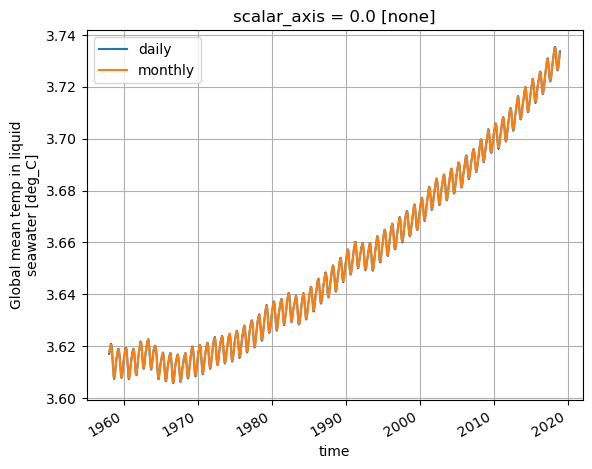

In [17]:
import matplotlib.pyplot as plt

dataset_dict["ocean_scalar_snapshot.1day"]["temp_global_ave"].plot(label="daily")
dataset_dict["ocean_scalar.1mon"]["temp_global_ave"].plot(label="monthly")

plt.legend()
_ = plt.grid()

Note, when there is only one dataset in an Intake-ESM datastore, it can be opened into an xarray Dataset using the `to_dask` method.

In [18]:
dataset = esm_datastore2.search(frequency="1mon").to_dask(progressbar=False)

dataset

<xarray.Dataset>
Dimensions:                (scalar_axis: 1, time: 732, nv: 2)
Coordinates:
  * scalar_axis            (scalar_axis) float64 0.0
  * time                   (time) datetime64[ns] 1958-01-14T12:00:00 ... 2018...
  * nv                     (nv) float64 1.0 2.0
Data variables: (12/19)
    total_mass_seawater    (time, scalar_axis) float32 dask.array<chunksize=(12, 1), meta=np.ndarray>
    total_volume_seawater  (time, scalar_axis) float32 dask.array<chunksize=(12, 1), meta=np.ndarray>
    eta_adjust             (time, scalar_axis) float32 dask.array<chunksize=(12, 1), meta=np.ndarray>
    pbot_adjust            (time, scalar_axis) float32 dask.array<chunksize=(12, 1), meta=np.ndarray>
    rhoave                 (time, scalar_axis) float32 dask.array<chunksize=(12, 1), meta=np.ndarray>
    eta_global             (time, scalar_axis) float32 dask.array<chunksize=(12, 1), meta=np.ndarray>
    ...                     ...
    total_ocean_heat       (time, scalar_axis) float32 dask.array<chunksize=(12, 1), meta=np.ndarray>
    total_net_sfc_heating  (time, scalar_axis) float32 dask.array<chunksize=(12, 1), meta=np.ndarray>
    average_T1             (time) datetime64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
    average_T2             (time) datetime64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
    average_DT             (time) timedelta64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
    time_bounds            (time, nv) timedelta64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
Attributes: (12/15)
    filename:                                 ocean_scalar.nc
    title:                                    ACCESS-OM2
    grid_type:                                mosaic
    grid_tile:                                1
    intake_esm_vars:                          ['total_mass_seawater', 'total_...
    intake_esm_attrs:realm:                   ocean
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  sea_water_mass,sea_water_volume...
    intake_esm_attrs:variable_cell_methods:   time: mean,time: mean,time: mea...
    intake_esm_attrs:filename:                ocean_scalar
    intake_esm_attrs:file_id:                 ocean_scalar
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean_scalar.1mon

## Passing a catalog query on to an Intake-ESM datastore

A common workflow when using the ACCESS-NRI catalog is to execute the same search on the ACCESS-NRI catalog and the resulting Intake-ESM datastores. For example, we might want to search for products containing a particular variable in the ACCESS-NRI catalog and then load datasets containing that variable from the resulting product datastore(s).

For example, let's search for all ACCESS-OM2 products with variable `temp_global_ave` at monthly frequency and get the datastores for all the resulting products. Each product datastore in `esm_datastore_dict` comprises multiple datasets, most of which don't include the variable we're interested in.  

In [19]:
nri_cat4 = nri_cat.search(model="ACCESS-OM2", frequency="1mon", variable="temp_global_ave")

esm_datastore_dict = nri_cat4.to_source_dict()

esm_datastore_dict

{'1deg_jra55_ryf9091_gadi': <1deg_jra55_ryf9091_gadi catalog with 9 dataset(s) from 9677 asset(s)>,
 '025deg_jra55_iaf_omip2_cycle6': <025deg_jra55_iaf_omip2_cycle6 catalog with 8 dataset(s) from 1830 asset(s)>,
 '025deg_jra55_iaf_omip2_cycle2': <025deg_jra55_iaf_omip2_cycle2 catalog with 8 dataset(s) from 1830 asset(s)>,
 '1deg_jra55_iaf_omip2_cycle5': <1deg_jra55_iaf_omip2_cycle5 catalog with 11 dataset(s) from 2013 asset(s)>,
 '025deg_jra55_iaf_omip2_cycle4': <025deg_jra55_iaf_omip2_cycle4 catalog with 8 dataset(s) from 1830 asset(s)>,
 '025deg_jra55_iaf_omip2_cycle1': <025deg_jra55_iaf_omip2_cycle1 catalog with 8 dataset(s) from 1830 asset(s)>,
 '025deg_jra55_iaf_omip2_cycle3': <025deg_jra55_iaf_omip2_cycle3 catalog with 9 dataset(s) from 1869 asset(s)>,
 '1deg_jra55_iaf_omip2_cycle4': <1deg_jra55_iaf_omip2_cycle4 catalog with 11 dataset(s) from 2013 asset(s)>,
 '1deg_jra55_iaf_omip2_cycle3': <1deg_jra55_iaf_omip2_cycle3 catalog with 11 dataset(s) from 2013 asset(s)>,
 '1deg_jra55_

So to load the data we want we need to execute the same search again (now on each of the datastores) to filter for only the datasets containing `temp_global_ave` at monthly frequency.

In [20]:
esm_datastore_dict_filtered = {
    name: datastore.search(frequency="1mon", variable="temp_global_ave")
    for name, datastore in esm_datastore_dict.items()
}

esm_datastore_dict_filtered

{'1deg_jra55_ryf9091_gadi': <1deg_jra55_ryf9091_gadi catalog with 1 dataset(s) from 78 asset(s)>,
 '025deg_jra55_iaf_omip2_cycle6': <025deg_jra55_iaf_omip2_cycle6 catalog with 1 dataset(s) from 61 asset(s)>,
 '025deg_jra55_iaf_omip2_cycle2': <025deg_jra55_iaf_omip2_cycle2 catalog with 1 dataset(s) from 61 asset(s)>,
 '1deg_jra55_iaf_omip2_cycle5': <1deg_jra55_iaf_omip2_cycle5 catalog with 1 dataset(s) from 61 asset(s)>,
 '025deg_jra55_iaf_omip2_cycle4': <025deg_jra55_iaf_omip2_cycle4 catalog with 1 dataset(s) from 61 asset(s)>,
 '025deg_jra55_iaf_omip2_cycle1': <025deg_jra55_iaf_omip2_cycle1 catalog with 1 dataset(s) from 61 asset(s)>,
 '025deg_jra55_iaf_omip2_cycle3': <025deg_jra55_iaf_omip2_cycle3 catalog with 1 dataset(s) from 61 asset(s)>,
 '1deg_jra55_iaf_omip2_cycle4': <1deg_jra55_iaf_omip2_cycle4 catalog with 1 dataset(s) from 61 asset(s)>,
 '1deg_jra55_iaf_omip2_cycle3': <1deg_jra55_iaf_omip2_cycle3 catalog with 1 dataset(s) from 61 asset(s)>,
 '1deg_jra55_iaf_omip2_cycle2': <1

To help avoid this sort of code duplication, the catalog `to_source` and `to_source_dict` methods accept an argument `pass_query` which if `True` tries to pass the most recent query on the ACCESS-NRI catalog on to the datastore(s).

In [21]:
esm_datastore_dict2 = nri_cat4.to_source_dict(pass_query=True)

esm_datastore_dict2

/jobfs/87810118.gadi-pbs/ipykernel_54042/3664144049.py:1: UserWarning: Unable to pass query on 'model' on to source '1deg_jra55_ryf9091_gadi' so this query is being skipped. This is usually because 'model' is not a valid query key in the source. For example, if the source is an intake-esm datastore, the column 'model' may not exist or may be called something else.
  esm_datastore_dict2 = nri_cat4.to_source_dict(pass_query=True)
/jobfs/87810118.gadi-pbs/ipykernel_54042/3664144049.py:1: UserWarning: Unable to pass query on 'model' on to source '025deg_jra55_iaf_omip2_cycle6' so this query is being skipped. This is usually because 'model' is not a valid query key in the source. For example, if the source is an intake-esm datastore, the column 'model' may not exist or may be called something else.
  esm_datastore_dict2 = nri_cat4.to_source_dict(pass_query=True)
/jobfs/87810118.gadi-pbs/ipykernel_54042/3664144049.py:1: UserWarning: Unable to pass query on 'model' on to source '025deg_jra55_

{'1deg_jra55_ryf9091_gadi': <1deg_jra55_ryf9091_gadi catalog with 1 dataset(s) from 78 asset(s)>,
 '025deg_jra55_iaf_omip2_cycle6': <025deg_jra55_iaf_omip2_cycle6 catalog with 1 dataset(s) from 61 asset(s)>,
 '025deg_jra55_iaf_omip2_cycle2': <025deg_jra55_iaf_omip2_cycle2 catalog with 1 dataset(s) from 61 asset(s)>,
 '1deg_jra55_iaf_omip2_cycle5': <1deg_jra55_iaf_omip2_cycle5 catalog with 1 dataset(s) from 61 asset(s)>,
 '025deg_jra55_iaf_omip2_cycle4': <025deg_jra55_iaf_omip2_cycle4 catalog with 1 dataset(s) from 61 asset(s)>,
 '025deg_jra55_iaf_omip2_cycle1': <025deg_jra55_iaf_omip2_cycle1 catalog with 1 dataset(s) from 61 asset(s)>,
 '025deg_jra55_iaf_omip2_cycle3': <025deg_jra55_iaf_omip2_cycle3 catalog with 1 dataset(s) from 61 asset(s)>,
 '1deg_jra55_iaf_omip2_cycle4': <1deg_jra55_iaf_omip2_cycle4 catalog with 1 dataset(s) from 61 asset(s)>,
 '1deg_jra55_iaf_omip2_cycle3': <1deg_jra55_iaf_omip2_cycle3 catalog with 1 dataset(s) from 61 asset(s)>,
 '1deg_jra55_iaf_omip2_cycle2': <1

```{note}
The warnings in the above output are telling us that the query on model was not passed on because there is no column "model" in the Intake-ESM datastores. The other queries on "variable" and "frequency" were passed on successfully so we're left with only one dataset in each datastore
```

Now that we have our appropriately filtered datastores, we can easily open and plot the data.

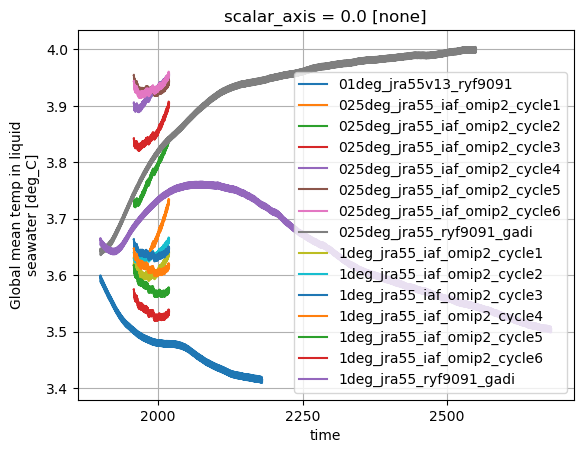

In [22]:
for idx, name in enumerate(sorted(esm_datastore_dict2.keys())):
    data = esm_datastore_dict2[name].to_dask(
        progressbar=False, xarray_open_kwargs=dict(use_cftime=True),
    )
    data["temp_global_ave"].plot(color=f"C{idx}", label=name)    
plt.legend()
plt.grid()

## A multi-model example

Let's use the ACCESS-NRI catalog to compare SST fields from three data products:

- An ACCESS-OM2 experiment: `1deg_jra55_iaf_omip2_cycle1`
- An ACCESS-ESM1.5 experiment: `HI_C_05_r1`
- An ACCESS-CM2 experiment: `bx944`

First we'll search directly for the products by their names and get the Intake-ESM datastores for those experiments. Here we use the `to_source_dict` method to load the datastores because there is more than one of them.

In [23]:
nri_cat5 = nri_cat.search(
    name=[
        "1deg_jra55_iaf_omip2_cycle1",
        "HI_C_05_r1",
        "bx944"
    ]
)

In [24]:
esm_datastore_dict3 = nri_cat5.to_source_dict()

esm_datastore_dict3

{'bx944': <bx944 catalog with 7 dataset(s) from 12150 asset(s)>,
 'HI_C_05_r1': <HI_C_05_r1 catalog with 11 dataset(s) from 7873 asset(s)>,
 '1deg_jra55_iaf_omip2_cycle1': <1deg_jra55_iaf_omip2_cycle1 catalog with 11 dataset(s) from 2013 asset(s)>}

Now we'll search on monthly SST within each datastore and open each monthly SST dataset as an xarray Dataset (here we use the `to_dask` method because there is only one dataset remaining in the Intake-ESM datastore after the search is applied).

In [ ]:
# Some useful keyword arguments to make opening with xarray faster
xarray_combine_by_coords_kwargs = dict(
    compat="override",
    data_vars="minimal", 
    coords="minimal",
)
xarray_open_kwargs = dict(
    use_cftime=True,
)
    
dataset_dict = {
    name: datastore.search(
        realm="ocean",
        variable="sst",
        frequency="1mon"
    ).to_dask(
        xarray_open_kwargs=xarray_open_kwargs, 
        xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs
    )
    for name, datastore in esm_datastore_dict3.items()
}

Now we can plot our data. We'll use a little function that receives our dictionary of datasets and plots all the SST fields on a provided date.

In [26]:
def plot_date(dataset_dict, time):
    """ Plot monthly SST at a provided time """
    nrows = len(dataset_dict)
    fig = plt.figure(figsize=(8, nrows*3))
    axs = fig.subplots(nrows,1)
    fig.suptitle(f'Monthly SST, {time}')
    
    for idx, (name, ds) in enumerate(dataset_dict.items()):
        ax = axs[idx]
        if "member" in ds.dims:
            ds = ds.isel(member=0)
        data = ds["sst"].sel(time=time).compute()
        # NOTE: there're better ways to deal with units, but this will do for now
        if (data > 273.15).any().item():
            data -= 273.15
        data.plot(ax=ax, cmap="viridis", vmin=-2, vmax=30)
        ax.set_title(name)
        ax.set_xlabel("")
        ax.set_ylabel("")
        
    fig.tight_layout()

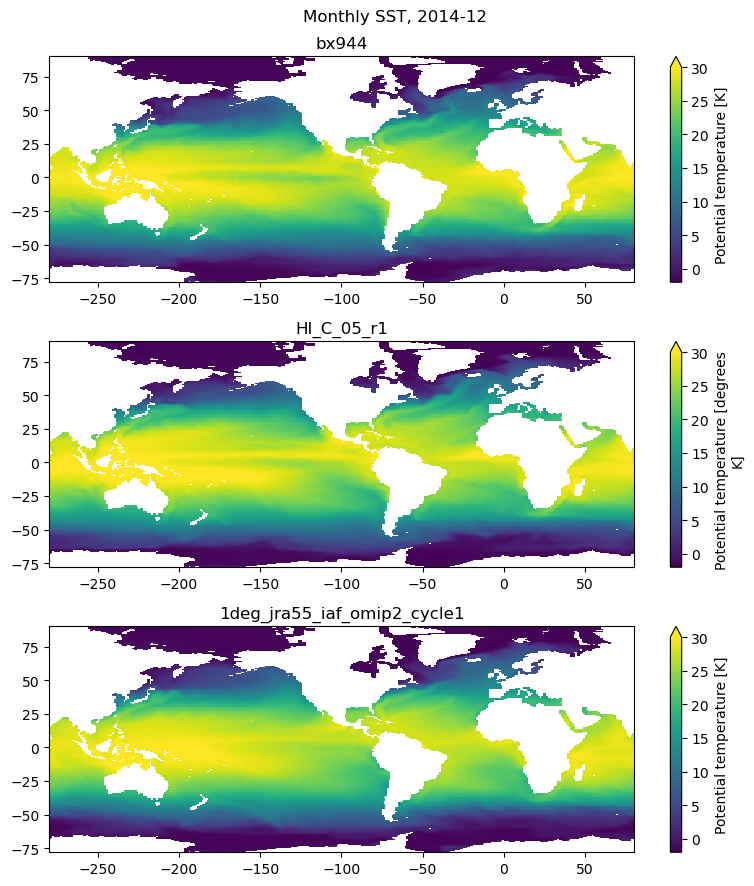

In [27]:
plot_date(dataset_dict, time="2014-12")

Maybe we'd also like to add some CMIP6 data to our plot? That's easy because the [NCI CMIP6 Intake-ESM datastores](https://opus.nci.org.au/pages/viewpage.action?pageId=213713098) are included in the ACCESS-NRI catalog.

In [28]:
cmip6_datastore = nri_cat.search(name="cmip6_fs38").to_source()

Let's search for and load one member of the ACCESS-ESM1-5 historical run.

In [29]:
ds = cmip6_datastore.search(
    source_id="ACCESS-ESM1-5", 
    table_id="Omon", 
    variable_id="tos", 
    experiment_id="historical", 
    member_id="r1i1p1f1",
    file_type="f"
).to_dask()

dataset_dict["CMIP6 ACCESS-ESM1.5 historical"] = ds.rename({"tos": "sst"})

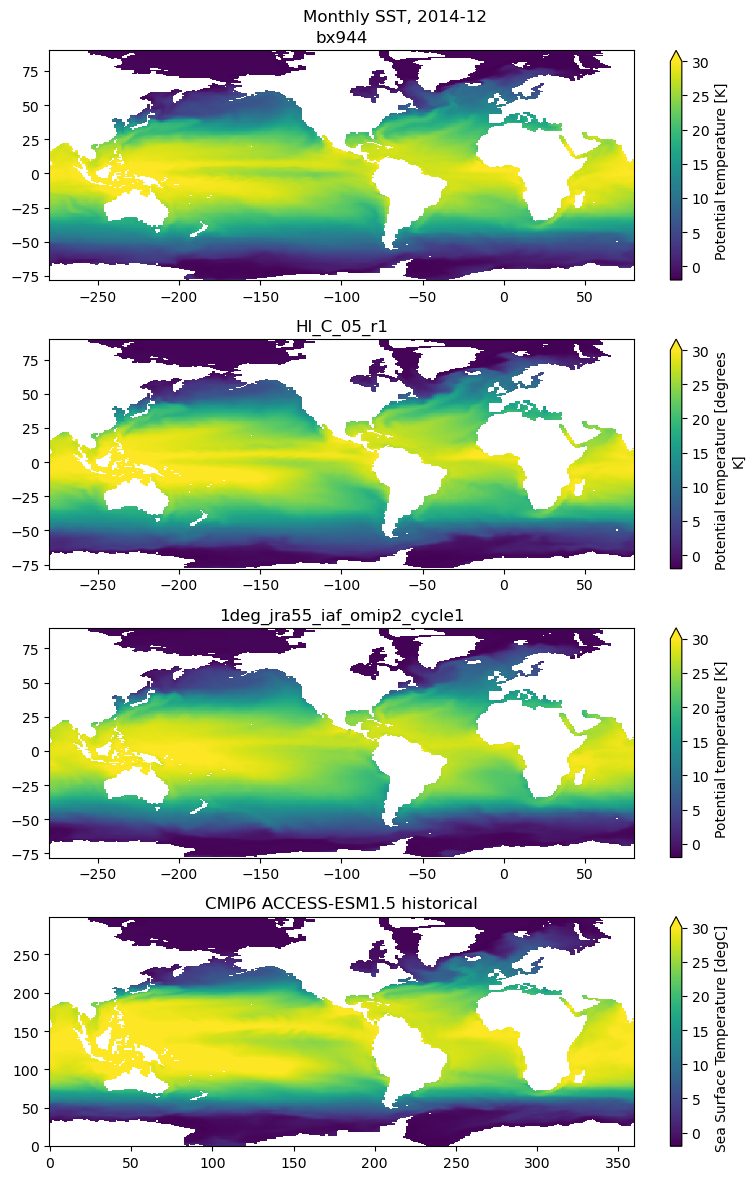

In [30]:
plot_date(dataset_dict, time="2014-12")

In [31]:
client.close()